# Redes densas con Keras

## Imports

In [3]:
from datetime import datetime
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Fijar semilla para reproducibilidad
# tf.random.set_seed(42) # Alternativa para TensorFlow
tf.keras.utils.set_random_seed(42)  # Alternativa para Keras


## Cargar dataset

In [4]:
# 1. Cargar datos
df = pd.read_csv("../data/Housing.csv")

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
df

## Dividir variables entradas y salidas

In [5]:
# 2. Variables de entrada (X), variables de salida (y)

# Variables de entrada
X = df.drop(columns="price")

# Variable de salida
y = df["price"]



## Dividir entrenamiento y prueba

In [6]:
# 3. Train / Test split (80% train y 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.20, random_state=42
# )

In [75]:
# X = X.to_numpy()
# y = y.to_numpy()

# indices = np.random.permutation(len(X))

# split = int(0.8 * X.shape[0])
# X_train, X_test = X[indices[:split]], X[indices[split:]]
# y_train, y_test = y[indices[:split]], y[indices[split:]]


## Preprocesamiento de variables

In [8]:
# 4. Identificar tipos de columnas
binary_cols = ["mainroad", "guestroom", "basement",
                "hotwaterheating", "airconditioning", "prefarea"]  # yes/no
multi_cols = ["furnishingstatus"]  # más de dos categorías
num_cols = X.select_dtypes(include=np.number).columns.tolist()  # numéricas

In [9]:
# 5. Definir preprocesamiento
# handle_unknown='ignore' evita errores si aparece una categoría nueva en test.
ohe_binary = OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse_output=False)
ohe_multi  = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ("num", MinMaxScaler(), num_cols),                      # Escalar numéricas
    ("bin", ohe_binary, binary_cols), # Codificar binarias
    ("multi", ohe_multi, multi_cols) # One-hot para múltiples
], sparse_threshold=0.0) # sparse_threshold=0.0 asegura que la salida sea un array denso

# 6. Crear pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

In [10]:
# 7. Transformar datos
# Ajustar solo con train
# Esto asegura que el preprocesamiento se aplica de manera consistente
# y evita fugas de información del test al entrenamiento.
pipeline.fit(X_train)

# Transformar train y test
# El resultado es un array NumPy con las características preprocesadas.
# Convertir a float32 para compatibilidad con TensorFlow
# y para reducir el uso de memoria.
# Esto es importante para evitar problemas de memoria en grandes datasets.
# También mejora la velocidad de entrenamiento en TensorFlow.
X_train_np = pipeline.transform(X_train).astype("float32")
X_test_np = pipeline.transform(X_test).astype("float32")

# Verificar dimensiones
print(X_train_np.shape, X_test_np.shape)

(436, 14) (109, 14)


In [79]:
# # Nombres de columnas resultantes (útil para depurar/inspeccionar)
# bin_names = pipeline.named_steps["preprocessor"].named_transformers_["bin"].get_feature_names_out(binary_cols).tolist()
# mul_names = pipeline.named_steps["preprocessor"].named_transformers_["multi"].get_feature_names_out(multi_cols).tolist()
# feature_names = num_cols + bin_names + mul_names

# print("Shape train:", X_train_np.shape, "| Shape test:", X_test_np.shape)
# print("Total features:", len(feature_names))
# print("Feature names:", feature_names)

## Modelos

In [22]:
# Baseline: predecir la media de TRAIN
yhat_med = np.full_like(y_test.values, y_train.median(), dtype=float)
mae_b = mean_absolute_error(y_test, yhat_med)
rmse_b = sqrt(((y_test - yhat_med)**2).mean())
r2_b = r2_score(y_test, yhat_med)
mape_b = (np.abs((y_test.values - yhat_med) / y_test.values)).mean()*100
print(f"Baseline  MAE: {mae_b:,.2f} | RMSE: {rmse_b:,.2f} | R²: {r2_b:,.4f} | MAPE: {mape_b:.2f}%")

Baseline  MAE: 1,763,903.67 | RMSE: 2,359,659.95 | R²: -0.1016 | MAPE: 36.71%


In [25]:
# Definir función para graficar errores y calcular métricas
def graficar_errores(y_real, y_hat):
    # Métricas de error
    mae = mean_absolute_error(y_real, y_hat)
    rmse = sqrt(mean_squared_error(y_real, y_hat))
    # Coeficiente de determinación
    # Rango típico: (−∞,1). 1 es perfecto; 0 equivale a predecir siempre la media; negativo = peor que la media.
    r2 = r2_score(y_real, y_hat)
    # MAPE = Mean Absolute Percentage Error
    # MAPE (porcentaje) para interpretar mejor magnitud del error
    mape = (np.abs((y_real - y_hat) / y_real)).mean()*100

    # Histograma de errores
    sns.histplot(y_hat - y_real, bins=20, alpha=0.7, label='Error de Predicción')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'MAE: {mae:.2f} | $\\mathbf{{RMSE}}$: {rmse:.2f} | R²: {r2:.4f} | MAPE: {mape:.2f}%')
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 1. Arquitectura: 2HL (128, 64)

#### 1.1. Definición del modelo

In [ ]:
# Definir arquitectura del modelo
model_128_64 = keras.Sequential([
    layers.Input(shape=(X_train_np.shape[1],)), # capa de entrada
    layers.Dense(128, activation="relu"), # primera capa oculta
    layers.Dense(64, activation="relu"), # segunda capa oculta
    layers.Dense(1)  # regresión (price)
])

model_128_64.compile(optimizer="adam", loss="mse", metrics=["mae"])

model_128_64.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 1.2. Entrenamiento del modelo

In [ ]:
# TensorBoard: carpeta con timestamp para no sobrescribir
log_dir = "../logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensor_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping: para evitar overfitting, se detiene si no mejora en val_loss
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20, # número de epochs sin mejora antes de parar
    restore_best_weights=True # al parar, restaura los pesos del mejor epoch (el de menor val_loss), en vez de dejar los de la última época.
)

# ModelCheckpoint: guarda el mejor modelo basado en val_loss
checkpoint = keras.callbacks.ModelCheckpoint(
        filepath="../models/model_128_64.keras",
        save_best_only=True,
        monitor="val_loss"
    )

# Entrenar el modelo
history = model_128_64.fit(
    X_train_np, y_train.values,
    #validation_split=0.2,
    validation_data=(X_test_np, y_test.values), # da mejor resultado que validation_split
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop, checkpoint, tensor_board],
    verbose=1  # 1 si querés ver el log
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 25234786746368.0000 - mae: 4706527.0000 - val_loss: 30129984110592.0000 - val_mae: 5007535.5000
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25234778357760.0000 - mae: 4706526.0000 - val_loss: 30129963139072.0000 - val_mae: 5007534.5000
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25234755289088.0000 - mae: 4706523.5000 - val_loss: 30129925390336.0000 - val_mae: 5007530.5000
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25234702860288.0000 - mae: 4706518.5000 - val_loss: 30129849892864.0000 - val_mae: 5007524.0000
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25234608488448.0000 - mae: 4706510.0000 - val_loss: 30129709383680.0000 - val_mae: 5007511.5000
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25234453299200.0000 - mae: 4706493.5000 - val_loss: 30129480794112.0000 - val_mae: 5007490.5000
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

In [64]:
# %load_ext tensorboard
# %tensorboard --logdir=log_dir

#### 1.3. Evaluación del modelo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


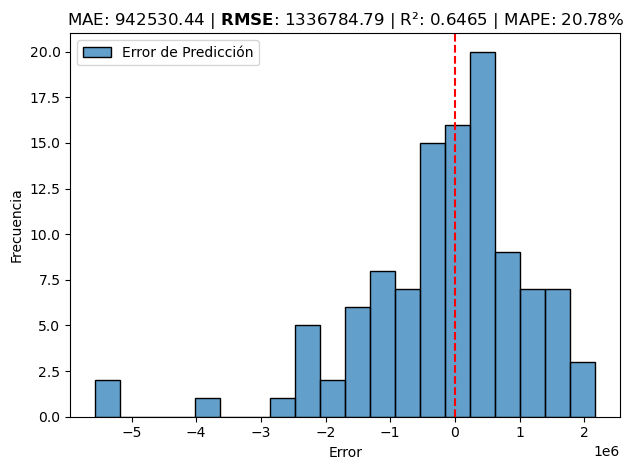

In [31]:
# Evaluación del modelo
model_128_64 = keras.models.load_model("../models/model_128_64.keras")

# Predicciones en test
y_pred = model_128_64.predict(X_test_np).ravel()

# Graficar errores
graficar_errores(y_test, y_pred)

# test_loss, test_mae = model_128_64.evaluate(X_test_np, y_test.values)
# test_rmse = np.sqrt(test_loss)

# #print(f"Test MSE : {test_mse:,.2f}")
# print(f"Test MAE : {test_mae:,.2f}")
# print(f"Test RMSE: {test_rmse:,.2f}")

In [ ]:
# # Guardar modelo y preprocesamiento
# import joblib
# model_128_64.save("keras_housing_model_128_64.keras")
# joblib.dump(pipeline, "preprocess_pipeline.pkl")

# Para inferencia:
# prep = joblib.load("preprocess_pipeline.pkl")
# model = keras.models.load_model("keras_housing_model.keras")
# X_new_np = prep.transform(X_new_df)
# y_new_pred = model.predict(X_new_np)


### 2. Arquitectura: 3HL (64, 32, 16)

#### 2.1. Definición del modelo

In [ ]:
# Definir arquitectura del modelo
model_64_32_16 = keras.Sequential([
    layers.Input(shape=(X_train_np.shape[1],)), # capa de entrada
    layers.Dense(64, activation="relu"), # primera capa oculta
    layers.Dense(32, activation="relu"), # segunda capa oculta
    layers.Dense(16, activation="relu"), # tercera capa oculta
    layers.Dense(1)  # regresión (price)
])

model_64_32_16.compile(optimizer="adam", loss="mse", metrics=["mae"])

model_64_32_16.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 2.2. Entrenamiento del modelo

In [23]:
# TensorBoard: carpeta con timestamp para no sobrescribir
log_dir = "../logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensor_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping: para evitar overfitting, se detiene si no mejora en val_loss
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20, # número de epochs sin mejora antes de parar
    restore_best_weights=True # al parar, restaura los pesos del mejor epoch (el de menor val_loss), en vez de dejar los de la última época.
)

# ModelCheckpoint: guarda el mejor modelo basado en val_loss
checkpoint = keras.callbacks.ModelCheckpoint(
        filepath="../models/model_64_32_16.keras",
        save_best_only=True,
        monitor="val_loss"
    )

# Entrenar el modelo
history = model_64_32_16.fit(
    X_train_np, y_train.values,
    #validation_split=0.2,
    validation_data=(X_test_np, y_test.values), # da mejor resultado que validation_split
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop, checkpoint, tensor_board],
    verbose=1  # 1 si querés ver el log
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 25234788843520.0000 - mae: 4706527.0000 - val_loss: 30129984110592.0000 - val_mae: 5007535.5000
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25234778357760.0000 - mae: 4706526.0000 - val_loss: 30129963139072.0000 - val_mae: 5007534.5000
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25234757386240.0000 - mae: 4706523.5000 - val_loss: 30129935876096.0000 - val_mae: 5007531.0000
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25234713346048.0000 - mae: 4706519.5000 - val_loss: 30129860378624.0000 - val_mae: 5007524.0000
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25234612682752.0000 - mae: 4706510.0000 - val_loss: 30129703092224.0000 - val_mae: 5007509.5000
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25234421841920.0000 - mae: 4706490.5000 - val_loss: 30129415782400.0000 - val_mae: 5007482.5000
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

#### 2.3. Evaluación del modelo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


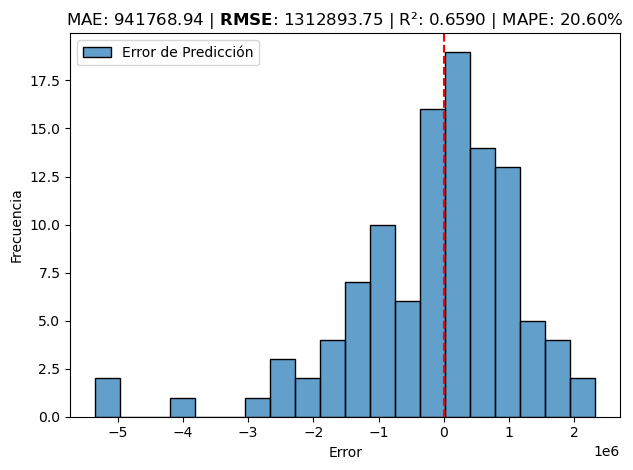

In [33]:
# Evaluación del modelo
model_64_32_16 = keras.models.load_model("../models/model_64_32_16.keras")

# Predicciones en test
y_pred = model_64_32_16.predict(X_test_np).ravel()

# Graficar errores
graficar_errores(y_test, y_pred)

### 3. Arquitectura: 3HL (32, 16, 8)

#### 3.1. Definición del modelo

In [ ]:
# Definir arquitectura del modelo
model_32_16_8 = keras.Sequential([
    layers.Input(shape=(X_train_np.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)  # salida lineal
])

model_32_16_8.compile(optimizer="adam", loss="mse", metrics=["mae"])

model_32_16_8.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_101 (Dense)               │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

#### 3.2. Entrenamiento del modelo

In [93]:
# TensorBoard: carpeta con timestamp para no sobrescribir
log_dir = "../logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensor_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping: para evitar overfitting, se detiene si no mejora en val_loss
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20, # número de epochs sin mejora antes de parar
    restore_best_weights=True # al parar, restaura los pesos del mejor epoch (el de menor val_loss), en vez de dejar los de la última época.
)

# ModelCheckpoint: guarda el mejor modelo basado en val_loss
checkpoint = keras.callbacks.ModelCheckpoint(
        filepath="../models/model_32_16_8.keras",
        save_best_only=True,
        monitor="val_loss"
    )

# Entrenar el modelo
history = model_32_16_8.fit(
    X_train_np, y_train.values,
    #validation_split=0.2,
    validation_data=(X_test_np, y_test.values), # da mejor resultado que validation_split
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop, checkpoint, tensor_board],
    verbose=1  # 1 si querés ver el log
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 25234788843520.0000 - mae: 4706527.0000 - val_loss: 30129988304896.0000 - val_mae: 5007536.0000
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25234786746368.0000 - mae: 4706527.0000 - val_loss: 30129984110592.0000 - val_mae: 5007535.5000
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25234782552064.0000 - mae: 4706526.0000 - val_loss: 30129977819136.0000 - val_mae: 5007535.5000
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25234774163456.0000 - mae: 4706525.5000 - val_loss: 30129967333376.0000 - val_mae: 5007534.5000
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25234759483392.0000 - mae: 4706523.5000 - val_loss: 30129942167552.0000 - val_mae: 5007532.0000
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25234728026112.0000 - mae: 4706521.0000 - val_loss: 30129898127360.0000 - val_mae: 5007528.0000
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

#### 3.3. Evaluación del modelo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


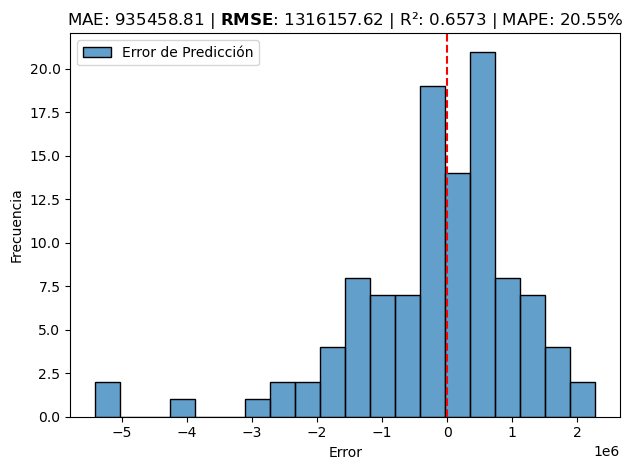

In [34]:
# Evaluación del modelo
model_32_16_8 = keras.models.load_model("../models/model_32_16_8.keras")

# Predicciones en test
y_pred = model_32_16_8.predict(X_test_np).ravel()

# Graficar errores
graficar_errores(y_test, y_pred)

In [97]:
# Predicciones en test
y_pred = model_32_16_8.predict(X_test_np).ravel()
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(((y_test - y_pred) ** 2).mean())
# Coeficiente de determinación
# Rango típico: (−∞,1). 1 es perfecto; 0 equivale a predecir siempre la media; negativo = peor que la media.
r2 = r2_score(y_test, y_pred)
# MAPE = Mean Absolute Percentage Error
# MAPE (porcentaje) para interpretar mejor magnitud del error
mape = (np.abs((y_test.values - y_pred) / y_test.values)).mean()*100

print(f"Test MAE : {mae:,.2f}")
print(f"Test RMSE: {rmse:,.2f}")
print(f"Test R² : {r2:,.4f}")
print(f"Test MAPE: {mape:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test MAE : 935,458.81
Test RMSE: 1,316,157.70
Test R² : 0.6573
Test MAPE: 20.55%
